# GHG
This notebook will be used to measure indicators for EDGI/EEW's "Climate Data Project" report. It will pull greenhouse gas emissions reported under EPA's Greenhouse Gas Reporting Program (GHGRP).

GHGRP only covers certain facilities - those who directly emit GHGs and those (e.g. oil refineries) who supply products (e.g. gasoline) that result in GHGs. GHGs from land use change is not included. Still, because it includes both direct emitters (e.g. coal-fired power plants) and suppliers (e.g. of the gas you burn in your car), the GHGRP is estimated to account for 85-90% of all US GHGs. Source: https://www.epa.gov/ghgreporting/ghgrp-and-us-inventory-greenhouse-gas-emissions-and-sinks

In [ ]:
%pip install requests
%pip install pandas
%pip install openpyxl
%pip install matplotlib
%pip install seaborn
%pip install plotly-express

  Using cached nbformat-5.10.4-py3-none-any.whl.metadata (3.6 kB)
Using cached nbformat-5.10.4-py3-none-any.whl (78 kB)

   ---------------------------------------- 0/7 [fastjsonschema]
   ----------- ---------------------------- 2/7 [attrs]
   ----------- ---------------------------- 2/7 [attrs]
   ----------------- ---------------------- 3/7 [referencing]
   ---------------------------- ----------- 5/7 [jsonschema]
   ---------------------------- ----------- 5/7 [jsonschema]
   ---------------------------- ----------- 5/7 [jsonschema]
   ---------------------------- ----------- 5/7 [jsonschema]
   ---------------------------- ----------- 5/7 [jsonschema]
   ---------------------------------- ----- 6/7 [nbformat]
   ---------------------------------- ----- 6/7 [nbformat]
   ---------------------------------- ----- 6/7 [nbformat]
   ---------------------------------- ----- 6/7 [nbformat]
   ---------------------------------------- 7/7 [nbformat]

Note: you may need to restart the kerne

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import requests, zipfile, io
import os
import numpy as np
import plotly.express

In [3]:
# Base dicts to run rest of code on
direct_emissions_field_names = {
    "Direct Point Emitters": "Total reported direct emissions",
    "Onshore Oil & Gas Prod.": "Total reported emissions from Onshore Oil & Gas Production ",
    "Gathering & Boosting": "Total reported emissions from Gathering & Boosting",
    "Transmission Pipelines": "Total reported direct emissions from Transmission Pipelines",
    "LDC - Direct Emissions": "Total reported direct emissions from Local Distribution Companies",
    "SF6 from Elec. Equip.": "Total reported direct emissions from Electrical Equipment Use"
}

# Define supplier-related columns
supplier_columns = [
    "GHG Quantity Associated with Coal-based liquid fuel production",
    "GHG Quantity Associated with Petroleum Products Produced",
    "GHG Quantity Associated with Petroleum Products Imported",
    "GHG Quantity Associated with Petroleum Products Exported",
    "GHG Quantity Associated with Natural Gas Supply",
    "GHG Quantity Associated with Natural Gas Liquids Supply",
    "GHG Quantity Associated with CO2 Supply "
]

direct_columns = [
    "Direct Point Emitters",
    "Onshore Oil & Gas Prod.",
    "Gathering & Boosting",
    "Transmission Pipelines",
    "LDC - Direct Emissions",
    "SF6 from Elec. Equip."
]

# Standard directory paths to retrieve/save data
DATA_DIR = "ghgrp_raw_data"
OUTPUT_DATA_DIR = "output_files"

In [3]:
# GHGRP
# Access: https://www.epa.gov/system/files/other-files/2024-10/2023_data_summary_spreadsheets.zip
# Data dictionary: https://www.epa.gov/rsei/rsei-data-dictionary-elements-data
# Pull the zip file into this notebook
url = "https://www.epa.gov/system/files/other-files/2024-10/2023_data_summary_spreadsheets.zip"
r = requests.get(url, verify=False)
# Unzip the file
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall("ghgrp_raw_data")

c:\Users\Ashok\Documents\GitHub\GHG-CDP\.venv\Lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.epa.gov'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


In [3]:
years = range(2010, 2024)
all_data = []

for year in years:
    filepath = os.path.join(DATA_DIR, f"ghgp_data_{year}.xlsx")
    print(f"Processing {filepath}...")

    year_dfs = []

    # Direct Emitters:
    for clean_name, col_header in direct_emissions_field_names.items():
        retrieve_from_sheet_name = clean_name
        if year < 2018 and retrieve_from_sheet_name == "Direct Point Emitters":
            retrieve_from_sheet_name = "Direct Emitters"

        try:
            df = pd.read_excel(filepath, sheet_name=retrieve_from_sheet_name, header=3)
        except Exception as e:
            print(f"  Skipping sheet {retrieve_from_sheet_name}: {e}")
            continue

        keep_cols = [c for c in ["Facility Id", "Facility Name", col_header] if c in df.columns]
        if len(keep_cols) < 3:
            continue

        df = df[keep_cols].copy()
        df.rename(columns={col_header: clean_name}, inplace=True)
        df["Year"] = year
        df = df.groupby(["Facility Id", "Facility Name", "Year"], as_index=False).sum(numeric_only=True)
        year_dfs.append(df)

    # Suppliers:
    try:
        df_sup = pd.read_excel(filepath, sheet_name="Suppliers", header=3)
        df_sup.replace("confidential", pd.NA, inplace=True)
        
        # Ensure all expected columns exist — add any that are missing as 0.0
        for col in supplier_columns:
            if col not in df_sup.columns:
                df_sup[col] = 0.0
            else:
                df_sup[col] = pd.to_numeric(df_sup[col], errors="coerce")

        # Now select columns (guaranteed to exist)
        keep_cols = ["Facility Id", "Facility Name"] + supplier_columns

        df_sup = df_sup[keep_cols].copy()
        df_sup["Year"] = year
        #print(df_sup.head())

        # Aggregate to facility-year level
        df_sup = df_sup.groupby(["Facility Id", "Facility Name", "Year"], as_index=False).sum(numeric_only=True)
        #print(df_sup.head())

        year_dfs.append(df_sup)

        missing = [col for col in supplier_columns if col not in df_sup.columns]
        if missing:
            print(f"  {year}: Missing supplier columns: {missing}")

    except Exception as e:
        print(f"  Skipping Suppliers sheet: {e}")
    
    # list of metadata columns that should appear only once per facility-year
    meta_cols = ["FRS Id", "City", "State", "Zip Code", "Address", "County", "Latitude", "Longitude"]

    # Merge all sheets for the year into one (keep first df fully, drop metadata from later dfs)
    if year_dfs:
        merged_year = year_dfs[0].copy()
        for df_other in year_dfs[1:]:
            df_other = df_other.copy()
            # remove metadata cols from df_other if they already exist in merged_year (avoid duplicate columns)
            cols_to_drop = [c for c in meta_cols if c in df_other.columns and c in merged_year.columns]
            if cols_to_drop:
                df_other = df_other.drop(columns=cols_to_drop)

            merged_year = pd.merge(
                merged_year,
                df_other,
                on=["Facility Id", "Facility Name", "Year"],
                how="outer"
            )
        all_data.append(merged_year)

# Final processing, aligning columns, etc.
aggregated_all_years = pd.concat(all_data, ignore_index=True)

# Ensure every possible column (across all years) exists, filling with NaN if absent
all_columns = sorted(set().union(*(df.columns for df in all_data)))
aggregated_all_years = aggregated_all_years.reindex(columns=all_columns)

aggregated_all_years["Total Direct Emissions"] = aggregated_all_years[direct_columns].sum(axis=1, skipna=True)
aggregated_all_years["Total Supplier Emissions"] = aggregated_all_years[supplier_columns].sum(axis=1, skipna=True)
aggregated_all_years["Total Emissions"] = (aggregated_all_years["Total Direct Emissions"] + aggregated_all_years["Total Supplier Emissions"])

print("\n=== Aggregated Emissions (Sample) ===")
print(aggregated_all_years.head())
if not os.path.exists(OUTPUT_DATA_DIR):
    os.mkdir(OUTPUT_DATA_DIR)
filepath = os.path.join(OUTPUT_DATA_DIR, f"aggregated_emissions_by_facility.csv")
aggregated_all_years.to_csv(filepath, index=False)


Processing ghgrp_raw_data\ghgp_data_2010.xlsx...
  Skipping sheet Onshore Oil & Gas Prod.: Worksheet named 'Onshore Oil & Gas Prod.' not found
  Skipping sheet Gathering & Boosting: Worksheet named 'Gathering & Boosting' not found
  Skipping sheet Transmission Pipelines: Worksheet named 'Transmission Pipelines' not found
  Skipping sheet LDC - Direct Emissions: Worksheet named 'LDC - Direct Emissions' not found
  Skipping sheet SF6 from Elec. Equip.: Worksheet named 'SF6 from Elec. Equip.' not found
Processing ghgrp_raw_data\ghgp_data_2011.xlsx...
  Skipping sheet Gathering & Boosting: Worksheet named 'Gathering & Boosting' not found
  Skipping sheet Transmission Pipelines: Worksheet named 'Transmission Pipelines' not found
Processing ghgrp_raw_data\ghgp_data_2012.xlsx...
  Skipping sheet Gathering & Boosting: Worksheet named 'Gathering & Boosting' not found
  Skipping sheet Transmission Pipelines: Worksheet named 'Transmission Pipelines' not found
Processing ghgrp_raw_data\ghgp_data_2

In [16]:
# Load your saved data (if you already wrote it to CSV)
filepath = os.path.join(OUTPUT_DATA_DIR, "aggregated_emissions_by_facility.csv")
aggregated_all_years = pd.read_csv(filepath)

# Compute total direct emissions per year
total_per_year = (
    aggregated_all_years
    .groupby("Year")[direct_columns]
    .sum(min_count=1)  # ignore all-NaN rows
    .reset_index()
)

# # Create a new column for total of *all* direct emissions combined
# total_per_year["Total Direct Emissions"] = total_per_year[direct_columns].sum(axis=1, skipna=True)

total_per_year.head()

filepath = os.path.join(OUTPUT_DATA_DIR, "aggregated_direct_emissions_by_year.csv")
total_per_year.to_csv(filepath, index=False)
print("\nSaved to aggregated_direct_emissions_by_year.csv")


Saved to aggregated_direct_emissions_by_year.csv


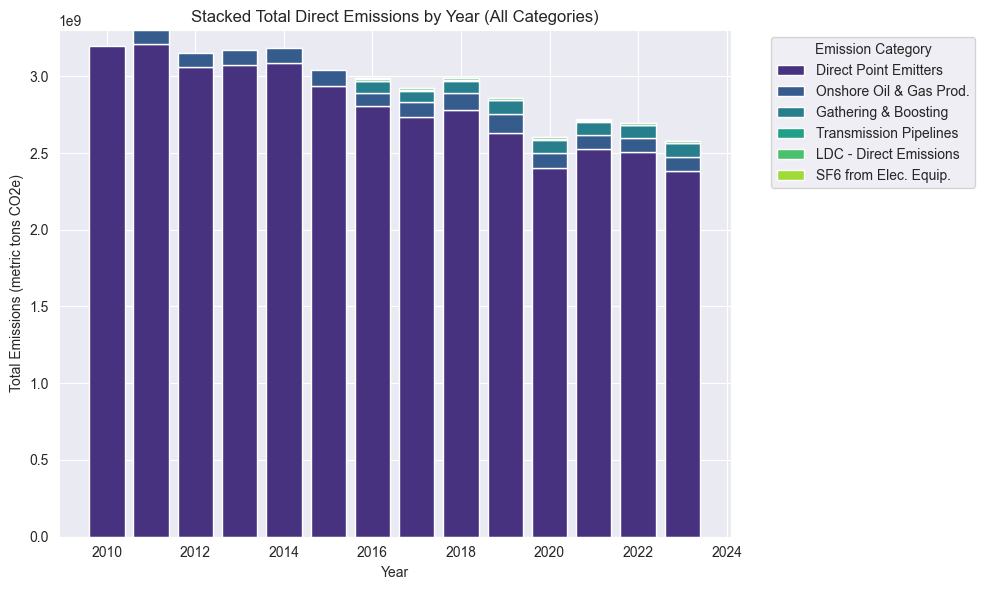

In [17]:
sns.set_style("darkgrid")

plt.figure(figsize=(10, 6))

filepath = os.path.join(OUTPUT_DATA_DIR, "aggregated_direct_emissions_by_year.csv")
total_per_year = pd.read_csv(filepath)

bottom_vals = None
colors = sns.color_palette("viridis", n_colors=len(direct_columns))

for i, col in enumerate(direct_columns):
    plt.bar(
        total_per_year["Year"],
        total_per_year[col],
        bottom=bottom_vals,
        color=colors[i],
        label=col
    )
    bottom_vals = (
        total_per_year[col]
        if bottom_vals is None
        else bottom_vals + total_per_year[col]
    )

plt.title("Stacked Total Direct Emissions by Year (All Categories)")
plt.xlabel("Year")
plt.ylabel("Total Emissions (metric tons CO2e)")
plt.legend(title="Emission Category", bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()


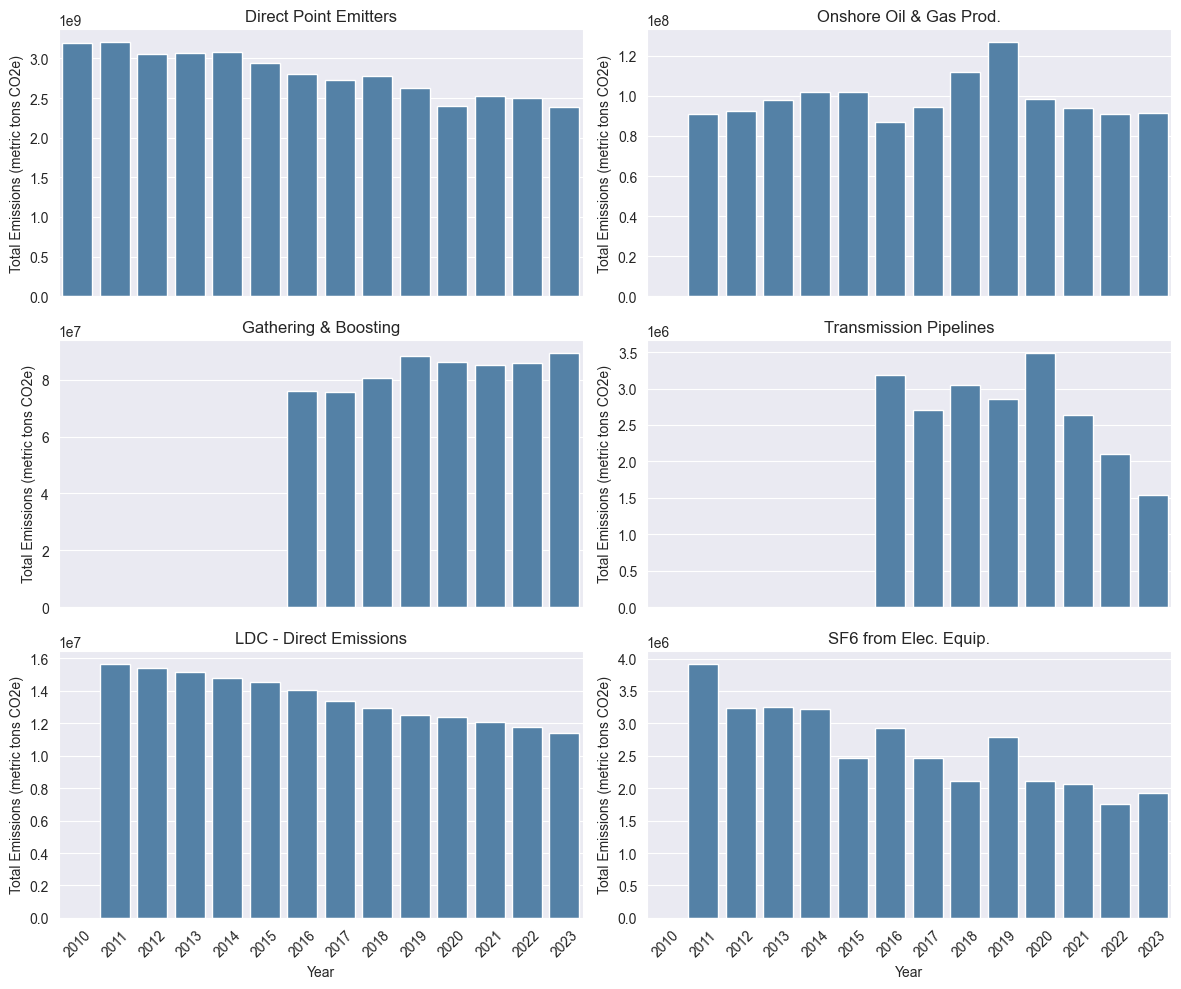

In [18]:
fig, axes = plt.subplots(3, 2, figsize=(12, 10), sharex=True)
axes = axes.flatten()

for i, col in enumerate(direct_columns):
    sns.barplot(
        data=total_per_year,
        x="Year",
        y=col,
        color="steelblue",
        ax=axes[i]
    )
    axes[i].set_title(col)
    axes[i].set_ylabel("Total Emissions (metric tons CO2e)")
    axes[i].set_xlabel("Year")
    axes[i].tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()


In [19]:
# Similar code as above, but now for suppliers.
# Load your saved data (if you already wrote it to CSV)
filepath = os.path.join(OUTPUT_DATA_DIR, "aggregated_emissions_by_facility.csv")
aggregated_all_years = pd.read_csv(filepath)
print(aggregated_all_years.head())
# Compute total direct emissions per year
total_per_year_suppliers = (
    aggregated_all_years
    .groupby("Year")[supplier_columns]
    .sum(min_count=1)  # ignore all-NaN rows
    .reset_index()
)

# Create a new column for total of *all* supplier emissions combined
# total_per_year_suppliers["Supplier Emissions"] = total_per_year_suppliers[supplier_columns].sum(axis=1, skipna=True)

total_per_year_suppliers.head()

filepath = os.path.join(OUTPUT_DATA_DIR, "aggregated_supplier_emissions_by_year.csv")
total_per_year_suppliers.to_csv(filepath, index=False)
print("\nSaved to aggregated_supplier_emissions_by_year.csv")

   Direct Point Emitters  Facility Id                    Facility Name  \
0             293290.944      1000001  PSE Ferndale Generating Station   
1             108094.104      1000002                Ardagh Glass Inc.   
2              78408.200      1000003                Ardagh Glass Inc.   
3              62346.096      1000004                Ardagh Glass Inc.   
4              74196.872      1000005                Ardagh Glass Inc.   

   GHG Quantity Associated with CO2 Supply   \
0                                       NaN   
1                                       NaN   
2                                       NaN   
3                                       NaN   
4                                       NaN   

   GHG Quantity Associated with Coal-based liquid fuel production  \
0                                                NaN                
1                                                NaN                
2                                                NaN             

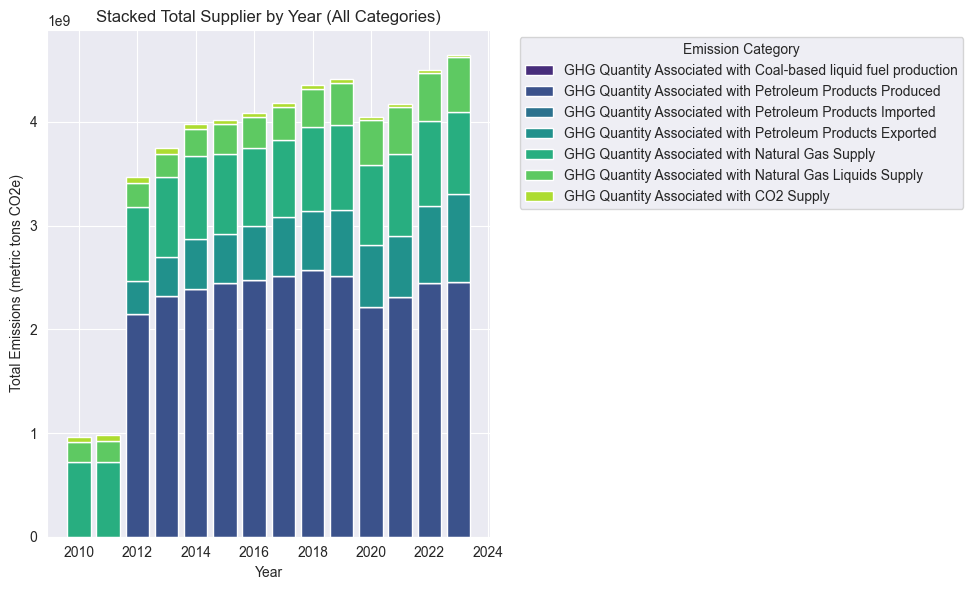

In [20]:
plt.figure(figsize=(10, 6))

filepath = os.path.join(OUTPUT_DATA_DIR, "aggregated_supplier_emissions_by_year.csv")
total_per_year_suppliers = pd.read_csv(filepath)

bottom_vals = None
colors = sns.color_palette("viridis", n_colors=len(supplier_columns))

for i, col in enumerate(supplier_columns):
    plt.bar(
        total_per_year_suppliers["Year"],
        total_per_year_suppliers[col],
        bottom=bottom_vals,
        color=colors[i],
        label=col
    )
    bottom_vals = (
        total_per_year_suppliers[col]
        if bottom_vals is None
        else bottom_vals + total_per_year_suppliers[col]
    )

plt.title("Stacked Total Supplier by Year (All Categories)")
plt.xlabel("Year")
plt.ylabel("Total Emissions (metric tons CO2e)")
plt.legend(title="Emission Category", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


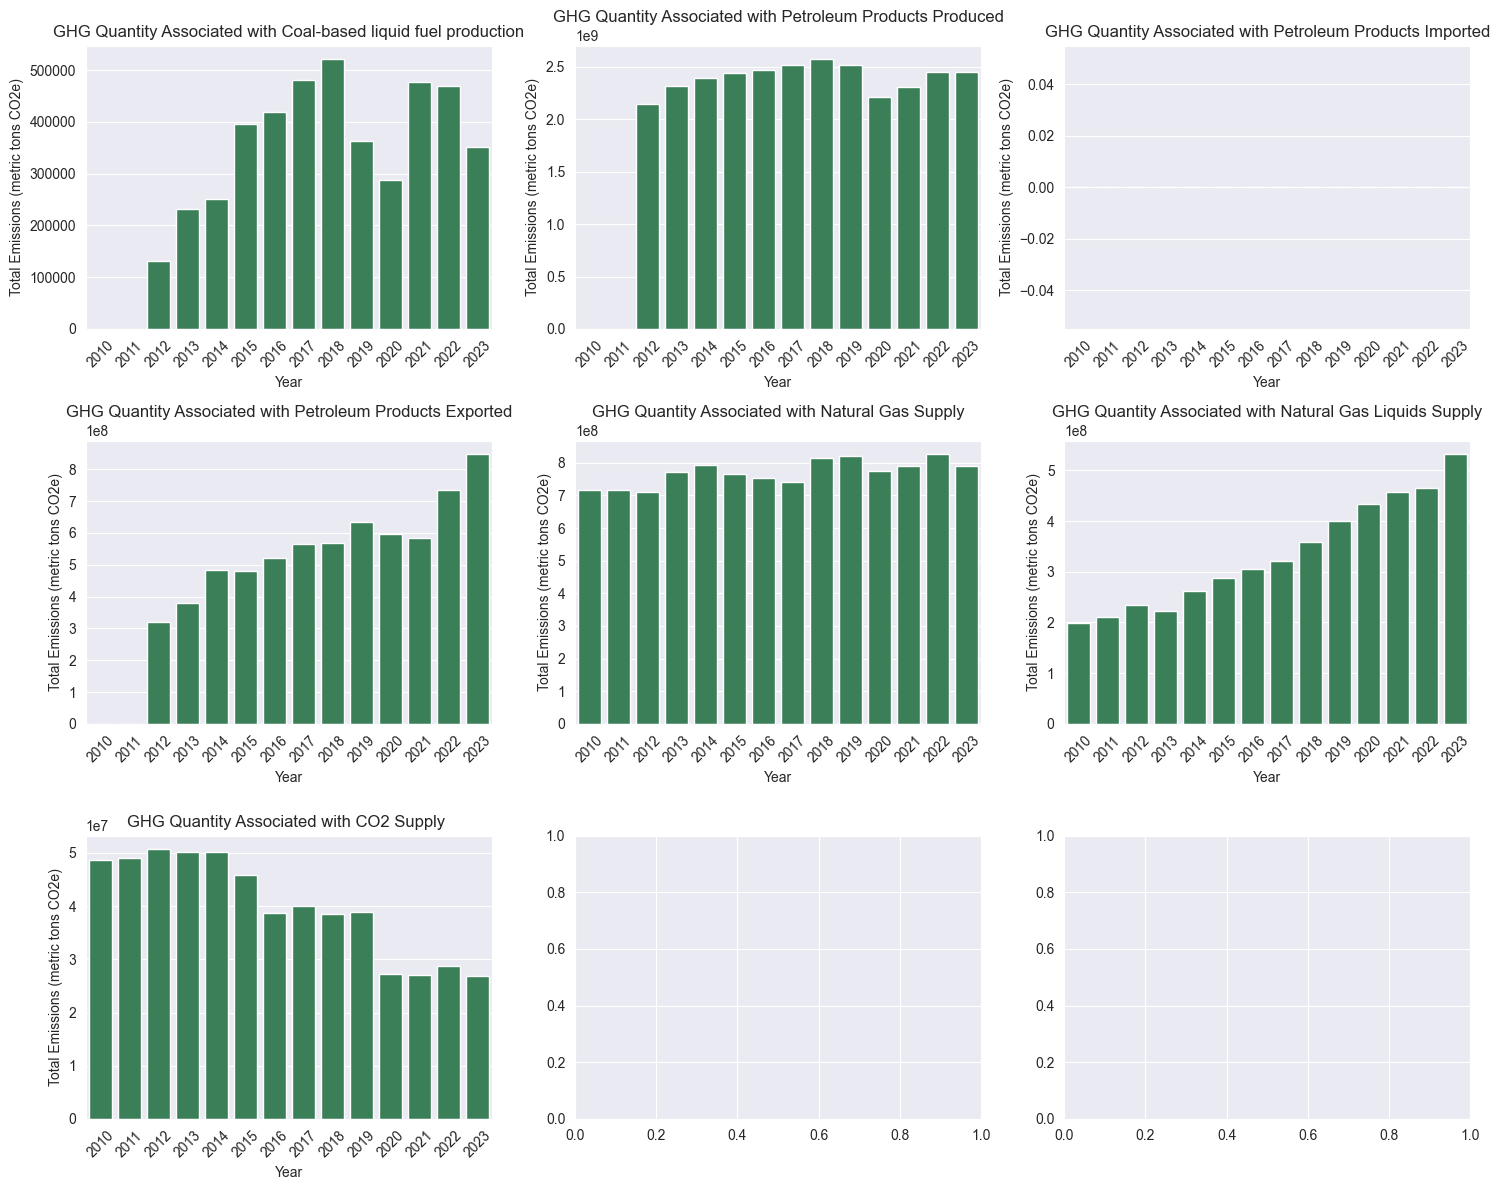

In [21]:
fig, axes = plt.subplots(3, 3, figsize=(15, 12), sharex=False)
axes = axes.flatten()

for i, col in enumerate(supplier_columns):
    sns.barplot(
        data=total_per_year_suppliers,
        x="Year",
        y=col,
        color="seagreen",
        ax=axes[i]
    )
    axes[i].set_title(col)
    axes[i].set_ylabel("Total Emissions (metric tons CO2e)")
    axes[i].set_xlabel("Year")
    axes[i].tick_params(axis="x", rotation=45)

# Hide any unused axes (since we have 7 categories but 9 axes in a 3x3 grid)
# for j in range(len(supplier_columns), len(axes)):
#     axes[j].axis('off')

plt.tight_layout()
plt.show()


In [4]:
# Load your saved data (if you already wrote it to CSV)
filepath = os.path.join(OUTPUT_DATA_DIR, "aggregated_emissions_by_facility.csv")
aggregated_all_years = pd.read_csv(filepath)

# Create lookup table for Address and other fields
file_2023 = os.path.join(DATA_DIR, "ghgp_data_by_year_2023.xlsx")
direct_2023 = pd.read_excel(file_2023, sheet_name="Direct Point Emitters", header=3)
supply_2023 = pd.read_excel(file_2023, sheet_name="Suppliers", header=3)

meta_cols = [
    "FRS Id", "Address", "City", "State", "Zip Code",
    "County", "Latitude", "Longitude", "Primary NAICS Code", "Latest Reported Industry Type (subparts)"
]

# Columns needed for merge
key_cols = ["Facility Id", "Facility Name"]

# Keep only key + metadata for each sheet
direct_lu = direct_2023[key_cols + meta_cols + ["Latest Reported Industry Type (sectors)"]].copy()
supply_lu = supply_2023[key_cols + meta_cols].copy()

# Set index to (Facility Id, Facility Name) pair
direct_lu_i = direct_lu.set_index(key_cols)
supply_lu_i = supply_lu.set_index(key_cols)

# Combine the direct/supplier lookup tables
lookup = direct_lu_i.combine_first(supply_lu_i).reset_index()
# Lookup table is done.

# these next lines verify that "lookup" has no entires with null/empty values for FRS Id
# FRS Id must be there, and an important entry, thus we check this and not necessarily other values.
# Output a list of these facilities with no FRSID to a file to inspect manually:
# facilities_with_no_FRSID = lookup[(lookup["FRS Id"].isna()) | (lookup["FRS Id"] == "")]
# print(facilities_with_no_FRSID)
# filepath = os.path.join(OUTPUT_DATA_DIR, "facilities_with_no_FRSID.csv")
# facilities_with_no_FRSID.to_csv(filepath, index=False)

aggregated_all_years = aggregated_all_years.merge(
    lookup,
    on=["Facility Id", "Facility Name"],
    how="left"
)
filepath = os.path.join(OUTPUT_DATA_DIR, "aggregated_emissions_by_facility_with_metadata.csv")
aggregated_all_years.to_csv(filepath)

top_emitters_facility = (
    aggregated_all_years
    .groupby(["Facility Id", "Facility Name"], as_index=False)[
        ["Total Direct Emissions", "Total Supplier Emissions"]
    ]
    .sum(min_count=1)
)

# top_emitters_facility = top_emitters_facility.merge(
#     lookup,
#     on=["Facility Id", "Facility Name"],
#     how="left"
# )
filepath = os.path.join(OUTPUT_DATA_DIR, "top_emitters_by_facility_with_metadata.csv")
top_emitters_facility.to_csv(filepath)

top_direct_emitters_facility = top_emitters_facility.sort_values("Total Direct Emissions", ascending=False)
top_supplier_emitters_facility = top_emitters_facility.sort_values("Total Supplier Emissions", ascending=False)

print("TOP DIRECT EMITTERS BY FACILITY:\n")
print(top_direct_emitters_facility.head(25))
print("\n\nTOP SUPPLIER EMITTERS BY FACILITY:\n")
print(top_supplier_emitters_facility.head(25))

TOP DIRECT EMITTERS BY FACILITY:

      Facility Id               Facility Name  Total Direct Emissions  \
7159      1007227           James H Miller Jr            2.770984e+08   
1043      1001051                     Scherer            2.231918e+08   
211       1000192                     Labadie            2.144483e+08   
699       1000676                      Monroe            2.099161e+08   
1182      1001194               Gen J M Gavin            2.019624e+08   
7411      1007504                 Martin Lake            2.019231e+08   
6800      1006868                  W A Parish            1.991424e+08   
1021      1001030                      Gibson            1.940176e+08   
1011      1001020                    Colstrip            1.852777e+08   
1494      1001505                       Bowen            1.760251e+08   
1180      1001192                 Jim Bridger            1.711769e+08   
7412      1007505                   Oak Grove            1.691235e+08   
960       1000967

In [4]:
# Helper function that picks the first "non null" entry for some data column.
# Used for anything that we don't wanna sum, but rather keep valid entries.
def first_non_null(series):
    valid = series.dropna()
    return valid.iloc[0] if len(valid) else np.nan

filepath = os.path.join(OUTPUT_DATA_DIR, "aggregated_emissions_by_facility_with_metadata.csv")
aggregated_all_years = pd.read_csv(filepath)

# Columns to sum
cols_to_sum = [
    "Total Emissions",
    "Total Direct Emissions",
    "Total Supplier Emissions"
    # plus any individual emission categories you want
] + direct_columns + supplier_columns

# Build dictionary which pandas will use to sum the appropriate columns
aggregation_dictionary = {}
for col in cols_to_sum:
    if col in aggregated_all_years.columns:
        aggregation_dictionary[col] = "sum"

state_grouped = aggregated_all_years.groupby(["State", "Year"]).agg(aggregation_dictionary)

print(state_grouped.head(25))
filepath = os.path.join(OUTPUT_DATA_DIR, "aggregated_emissions_by_state.csv")
state_grouped.to_csv(filepath)
# The following lines are important, as they save it to the json format which will be used
# externally for showing this data on a javascript application
filepath = os.path.join(OUTPUT_DATA_DIR, "aggregated_emissions_by_state.json")
state_grouped.reset_index().to_json(filepath, orient="records")

            Total Emissions  Total Direct Emissions  Total Supplier Emissions  \
State Year                                                                      
AK    2010     1.128728e+07            1.128728e+07              0.000000e+00   
      2011     1.194871e+07            1.194871e+07              0.000000e+00   
      2012     2.601983e+07            1.246488e+07              1.355495e+07   
      2013     2.667073e+07            1.205207e+07              1.461866e+07   
      2014     3.133079e+07            1.815887e+07              1.317192e+07   
      2015     3.119096e+07            1.849620e+07              1.269476e+07   
      2016     2.670149e+07            1.496579e+07              1.173570e+07   
      2017     2.973265e+07            1.519513e+07              1.453752e+07   
      2018     2.818813e+07            1.423083e+07              1.395730e+07   
      2019     2.788514e+07            1.432415e+07              1.356100e+07   
      2020     2.640962e+07 

C:\Users\Ashok\AppData\Local\Temp\ipykernel_5716\1426250368.py:36: UserWarning:

Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.

c:\Users\Ashok\Documents\GitHub\GHG-CDP\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.



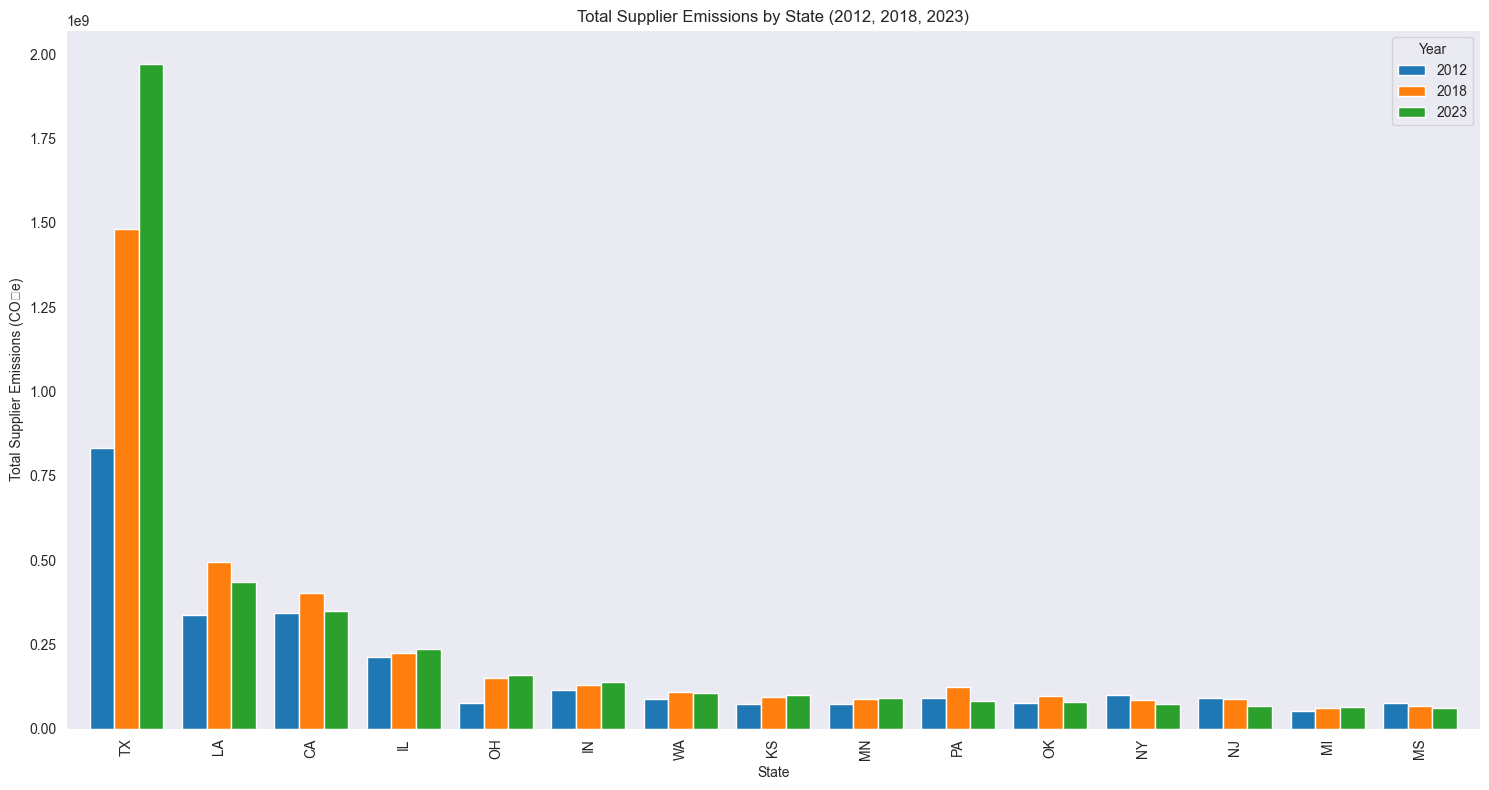

In [12]:
# Graph view of state-level emissions data
sns.set_style("dark")

def plot_state_emissions_grouped(years, emissions_category="Total Emissions"):
    """
    Plot grouped bar chart of state emissions for multiple years.
    States are ordered by emissions amount in the last year given, descending.
    """

    # Ensure years are sorted
    years = sorted(years)

    # Slice all requested years
    df_slice = (
        state_grouped
        .loc[(slice(None), years), emissions_category]
        .unstack("Year")
    )

    # Sort states by the last year's emissions, take only the top 15
    df_slice = df_slice.sort_values(years[-1], ascending=False).head(15)

    # Plot
    ax = df_slice.plot(
        kind="bar",
        figsize=(15, 8),
        width=0.8
    )

    ax.set_title(f"{emissions_category} by State ({', '.join(map(str, years))})")
    ax.set_xlabel("State")
    ax.set_ylabel(f"{emissions_category} (CO₂e)")
    ax.legend(title="Year")
    ax.tick_params(axis="x", rotation=90)

    plt.tight_layout()
    plt.show()

category = "Total Supplier Emissions"
plot_state_emissions_grouped([2012, 2018, 2023], emissions_category=category)

In [13]:
filepath = os.path.join(OUTPUT_DATA_DIR, "aggregated_emissions_by_state.csv")
state_grouped = pd.read_csv(filepath, index_col=[0,1])

year = 2010
emissions_category = "Total Direct Emissions"

state_grouped_one_category = (
    state_grouped[emissions_category]
    .reset_index()
)

fig = plotly.express.choropleth(
    state_grouped_one_category[state_grouped_one_category['Year'] == year],
    locations="State",
    locationmode="USA-states",
    color=emissions_category,
    scope="usa",
    color_continuous_scale="OrRd",
    labels={emissions_category: f"tons CO₂e"},
    width=700,
    height=500,
)

years = sorted(state_grouped_one_category["Year"].unique())

fig.frames = [
    dict(
        name=str(year),
        data=[
            dict(
                type="choropleth",
                locations=state_grouped_one_category[state_grouped_one_category["Year"] == year]["State"],
                z=state_grouped_one_category[state_grouped_one_category["Year"] == year][emissions_category]
            )
        ],
        layout=dict(title_text=f"{emissions_category}: {year}")
    )
    for year in years
]

fig.update_layout(
    title_text=f"{emissions_category}: {year}",
    title_x=0.5,
    geo=dict(
        showlakes=False,
        showland=True,
        landcolor="white",
        showcountries=False,
        showcoastlines=False,
        showframe=False
    ),
    margin=dict(l=20, r=20, t=60, b=20)
)

fig.update_layout(
    sliders=[{
        "active": 0,
        "pad": {"t": 50},
        "steps": [
            {
                "method": "animate",
                "label": str(year),
                "args": [
                    [str(year)],
                    {
                        "frame": {"duration": 300, "redraw": True},
                        "mode": "immediate",
                        "transition": {"duration": 200}
                    }
                ],
            }
            for year in years
        ],
    }]
)

fig.show()